# Оглавление
* [Описание проекта](#b0)
* [1. Загрузка и предобработка данных](#b1)
* [2. Подготовка выборок для обучения моделей.](#b2)
* [3. Обучение моделей](#b3)
* [4. Сравнение моделей](#b4)
* [5. Проверка модели](#b5)

# Описание проекта<a class="anchor" id="b0"></a>


Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Необходимо построить модель, которая на основе данных о технических характеристиках, комплектации и ценах других автомобилей  умеет определять рыночную стоимость автомобиля. 

Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

Для оценки качества моделей использовать метрику RMSE. Значение метрики RMSE должно быть меньше 2500.

### Описание данных
Данные находятся в файле /data/autos.csv. 

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from time import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
from catboost import CatBoostRegressor

C:\Users\alena\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\alena\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\alena\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\alena\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is

# 1. Загрузка и предобработка данных<a class="anchor" id="b1"></a>


Загрузим данные в переменную data и посмотрим общую информацию о таблице

In [2]:
data = pd.read_csv('data/autos.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В таблице 354369 записей об автомобилях, есть пропуски, некорректно выбраны типы данных в столбцах DateCrawled, DateCreated, LastSeen (необходим формат даты).

### 1.1. Удаление неинформативных признаков

Очевидно, что на целевой признак (Price — цена автомобиля в евро), не оказывают существенного влияния следующие из предоставленных признаков:

* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* NumberOfPictures — количество фотографий автомобиля
* DateCrawled — дата скачивания анкеты из базы (у нас останется столбец DateCreated — дата создания анкеты)
* RegistrationMonth — месяц регистрации автомобиля

Удалим их, чтобы моедели обучались корректней и быстрее.

In [3]:
data = data.drop(['PostalCode', 'LastSeen', 'NumberOfPictures', 'DateCrawled', 'RegistrationMonth'], axis=1)

### 1.2. Преобразование типов

Данные в столбце DateCreated приведем к нужному типу даты, а затем оставим только 1 поле -- год создания анкеты, так как это наиболее важный признак Чтобы не было ошибок, сразу удалим строки с аномальными значениями: год регистрации <=1950 или >=2024.

In [4]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format = '%Y-%m-%d %H:%M:%S')
data['YearCreated'] = data['DateCreated'].dt.year
data = data.drop(['DateCreated'], axis=1)
data = data[((data['RegistrationYear'] > 1950) & (data['RegistrationYear'] < 2023))]

### 1.3. Обработка пропусков

Посмотрим, в каких столбцах есть пропуски, а также на их количество

In [5]:
data.isna().sum()

Price                   0
VehicleType         37245
RegistrationYear        0
Gearbox             19597
Power                   0
Model               19534
Kilometer               0
FuelType            32677
Brand                   0
Repaired            70877
YearCreated             0
dtype: int64

Пропуски есть в 5 категориальных столбцах: VehicleType, Gearbox, Model, FuelType, Repaired. Каждый из этих признаков оказывает существенное влияние на цену автомобиля, при этом признаки категориальные. То есть такие пропуски нельзя заполнять, например, наиболее распространенным значением по столбцу, случайным.

In [6]:
print('Строк с хотя бы 1 пропуском:', data[data.isna().sum(axis=1) > 0].shape[0])

Строк с хотя бы 1 пропуском: 108216


Удалять все строки с пропусками тоже некорректно: так мы потеряем около четверти всех оставшихся на данный момент данных, и при попытке будущих пользователей рассчитать стоимость своего автомобиля они также могут захотеть оставить пропуски в некоторых их этих столбцов. Но если в одной строке пропущено много значений из этих 5 столбцов, то рассчитать корректно стоимость аавтомобиля будет невозможно, так как как, опять же, они все оказывают существенное влияние на целевой признак. Посмотрим на количество строк  с соответствующим количеством пропусков

In [7]:
print('Количество строк с соответствующим количеством пропусков')
for na_amount in range(1, 6):
    print(f'Количество пропусков: {na_amount} -- количество строк: {data[data.isna().sum(axis=1) == na_amount].shape[0]}')

Количество строк с соответствующим количеством пропусков
Количество пропусков: 1 -- количество строк: 64262
Количество пропусков: 2 -- количество строк: 26167
Количество пропусков: 3 -- количество строк: 9956
Количество пропусков: 4 -- количество строк: 5689
Количество пропусков: 5 -- количество строк: 2142


Можно удалить строки, в которых не менее 3 пропусков, а в будущем приложении ставить ограничение на количество пропсуков. Так мы потеряем около 7000 (то есть 2%) всех оставшихся записей, что в целом немного, и при этом сможем давать более корректные прогнозы стоимости. 

In [8]:
max_allowed_na_amount = 2
data = data[data.isna().sum(axis=1) <= max_allowed_na_amount]

Остальные пропуски заполним значением 'unspecified'

In [9]:
new_na_value = 'unspecified'
data = data.fillna(new_na_value)
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
YearCreated         0
dtype: int64

### 1.4. Анализ данных и обработка аномалий


#### Price
Сначала проанализируем значения целевого столбца Price. Построим гистограмму, ящик с усами и выведем статистическую информацию

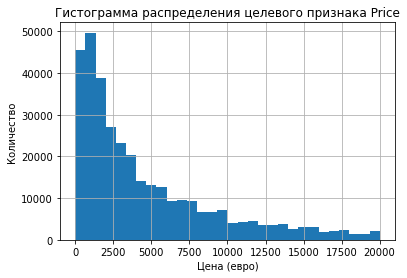

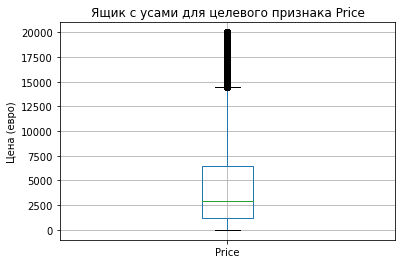

count    336213.000000
mean       4552.861008
std        4542.557370
min           0.000000
25%        1199.000000
50%        2899.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [10]:
plt.title('Гистограмма распределения целевого признака Price')
plt.xlabel('Цена (евро)')
plt.ylabel('Количество')
data['Price'].hist(bins=30)
plt.show()

plt.title('Ящик с усами для целевого признака Price')
plt.ylabel('Цена (евро)')
data.boxplot('Price')
plt.show()
data['Price'].describe()

По гистограмме видно, что данные сильно смещены вправо. Согласно статистической информации, среднее примерно в два раза болше медианы. То есть в данных много маленьких значений и выбросов в большую сторону. Это наглядно продемонстрировано и на ящике с усами.

Максимальная цена составляет 20000 евро, что является вполне адекватным, то есть большие значения нельзя назвать выбросами. Но вот пик цены в районе нуля -- явная аномалия. Оставим в данных только те записи, где цена автомобиля больше 400 евро. 

In [11]:
min_price = 400
data = data[data['Price'] > min_price]

#### Категориальные признаки: VehicleType, Gearbox, Model, FuelType, Brand, Repaired

Теперь рассмотрим категориальные признаки VehicleType, Gearbox, Model, FuelType, Brand, Repaired на предмет наличия скрытых дублей или аномалий. Выведем все встречающиеся значения и их долю в каждом столбце



In [12]:
categorial_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
for feature in categorial_features:
    print('Признак:', feature)
    print('Принимаемые значения:')
    print(data[feature].value_counts(normalize=True))
    print()

Признак: VehicleType
Принимаемые значения:
sedan          0.276195
small          0.222899
wagon          0.196361
bus            0.089536
convertible    0.062695
unspecified    0.058192
coupe          0.047877
suv            0.037517
other          0.008729
Name: VehicleType, dtype: float64

Признак: Gearbox
Принимаемые значения:
manual         0.773290
auto           0.201883
unspecified    0.024826
Name: Gearbox, dtype: float64

Признак: Model
Принимаемые значения:
golf                  0.083082
other                 0.069773
3er                   0.058923
polo                  0.034055
unspecified           0.032260
                        ...   
samara                0.000016
rangerover            0.000013
serie_3               0.000010
range_rover_evoque    0.000006
serie_1               0.000003
Name: Model, Length: 251, dtype: float64

Признак: FuelType
Принимаемые значения:
petrol         0.624403
gasoline       0.307874
unspecified    0.048463
lpg            0.016194
cng     

Скрытых дублей нет, но следует отметить несколько моментов.

Во-первых, можно заметить, что в некоторых столбцах (например, FuelType) есть значения 'other'. Здесь можно предложить следующее: отнести пропуски (то, что мы заполнили как 'unspecified') к категории 'other'. Однако мы этого делать не будем, так как неуказанное значение не обязательно относится к этой категории, а значения столбцов оказывают значительное влияние на цену автомобиля, то есть такое объединение категорий может значительно испортить исходные данные.

Во-вторых, можно отметить, что некоторые значения встречаются очень редко (например, значение range_rover_evoque в поле Model -- всего в 0.000007 доле случаев). Если некоторые значения встречаются редко, то их лучше объединить в одну группу, чтобы модель не концентрировалась на частных случаях, не переобучалась.

Выставим следующую границу: будем считать, что некоторое значение встречается редко, если оно представлено менее, чем 0.05% случаев (то есть его доля < 0.0005). Все редкие значения по каждому столбцу объединим в одну категорию -- 'other'

In [13]:
min_prop = 0.0005

for feature in categorial_features:
    proportions = data[feature].value_counts(normalize=True)
    data[feature] = data[feature].apply(lambda x: x if proportions[x] >= min_prop else 'other')
    
for feature in categorial_features:
    print('Признак:', feature)
    print('Принимаемые значения:')
    print(data[feature].value_counts(normalize=True))
    print()

Признак: VehicleType
Принимаемые значения:
sedan          0.276195
small          0.222899
wagon          0.196361
bus            0.089536
convertible    0.062695
unspecified    0.058192
coupe          0.047877
suv            0.037517
other          0.008729
Name: VehicleType, dtype: float64

Признак: Gearbox
Принимаемые значения:
manual         0.773290
auto           0.201883
unspecified    0.024826
Name: Gearbox, dtype: float64

Признак: Model
Принимаемые значения:
other          0.084539
golf           0.083082
3er            0.058923
polo           0.034055
unspecified    0.032260
                 ...   
captiva        0.000538
ypsilon        0.000525
x_type         0.000509
calibra        0.000509
mustang        0.000506
Name: Model, Length: 183, dtype: float64

Признак: FuelType
Принимаемые значения:
petrol         0.624403
gasoline       0.307874
unspecified    0.048463
lpg            0.016194
cng            0.001718
hybrid         0.000716
other          0.000632
Name: FuelTyp

#### Power

Построим ящик с усами и выведем статистическую информацию для столбца Power

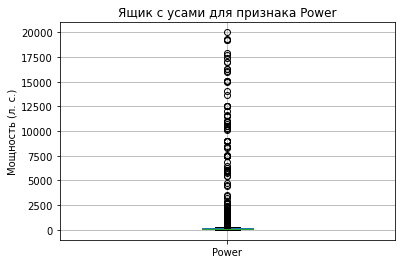

count    310234.000000
mean        116.297543
std         187.771028
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: Power, dtype: float64

In [14]:
plt.title('Ящик с усами для признака Power')
plt.ylabel('Мощность (л. с.)')
data.boxplot('Power')
plt.show()

data['Power'].describe()

Очевидно, что в данных много выбросов в бОльшую сторону, максимальное значение составляет 20000, тогда как 75-ти процентная квантиль находится на уровне 146, а медиана и среднее -- около 100. Также есть аномальные нулевые значения. 

Оставим только строки, где значение столбца Power больше нуля и меньше 99-ти процентной квантили

In [15]:
prev_len = data.shape[0]
data = data[data['Power'] > 0]
max_power = data['Power'].quantile(q=0.99)
data = data[data['Power'] < max_power]
cur_len = data.shape[0]
print(f'Удалено {prev_len - cur_len} записей')

Удалено 27124 записей


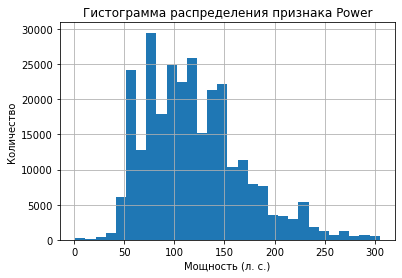

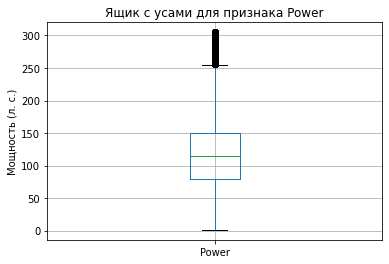

In [16]:
plt.title('Гистограмма распределения признака Power')
plt.xlabel('Мощность (л. с.)')
plt.ylabel('Количество')
data['Power'].hist(bins=30)
plt.show()

plt.title('Ящик с усами для признака Power')
plt.ylabel('Мощность (л. с.)')
data.boxplot('Power')
plt.show()

Теперь распределения выглядят более адекватно

#### Kilometer
Проанализируем значения столбца Kilometer. Построим гистограмму и выведем статистическую информацию

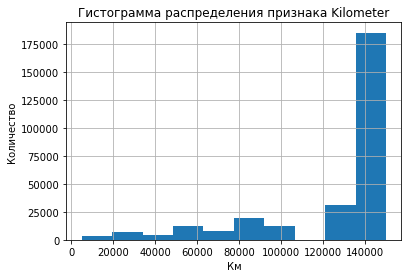

count    283110.000000
mean     127780.262089
std       36890.364362
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [17]:
plt.title('Гистограмма распределения признака Kilometer')
plt.xlabel('Км')
plt.ylabel('Количество')
data['Kilometer'].hist()
plt.show()

data['Kilometer'].describe()

Значения выглядят адекватно

#### Даты: RegistrationYear и YearCreated

<AxesSubplot:>

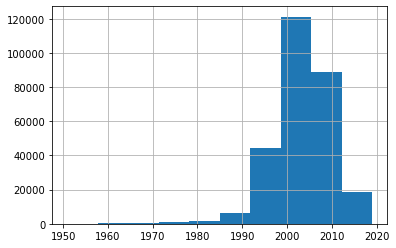

In [18]:
data['RegistrationYear'].hist()

<AxesSubplot:>

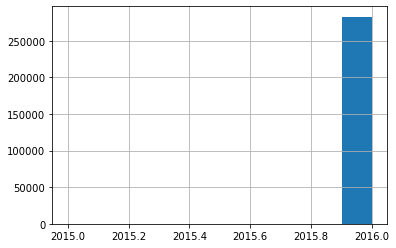

In [19]:
data['YearCreated'].hist()

С этими данными также все в порядке

# 2. Подготовка выборок для обучения моделей.<a class="anchor" id="b2"></a>


Будем пробовать обучать следующие модели: сначала попробуем использовать DecisionTreeRegressor как одну из самых простых моделей, затем -- ансамбль деревьев RandomForestRegressor, который усредняет ответы отдельных деревьев (зачастую таких моделей оказывается достаточно), а затем применим бустинг с помощью библиотек LightGBM и CatBoost. Для всех моделей будем пробовать различные наборы гиперпараметров и выбирать наилучшие. Модели будем оценивать по времени обучения на обучающей выборке и RMSE и времени предсказания на валидационной выборке. Но если модель не удовлетворяет требуемому качеству, то и время для нее замерять бессмыслено

Чтобы применить модели DecisionTreeRegressor и RandomForestRegressor, необходимо обработать категориальные признаки, например, техникой порядкового кодирования (Ordinal Encoding). Библиотеки LightGBM и CatBoost сами работают с категориальными признаками, но порядковое кодирование сохранит данные в тех же столбцах, просто переименовав принимаемые значения, поэтому на их работе данное преобразование не скажется

Разобьем данные на признаки и целевой признак, а также на тренировочную, тестовую и валидационную выборки в отношении 3:1:1. Закодируем категориальные признаки обучения порядковым кодированием.


In [20]:
enc = OrdinalEncoder()
enc.fit(data[categorial_features])
data[categorial_features] = enc.transform(data[categorial_features])


data_target = data['Price']
data_features = data.drop('Price', axis=1)

features_train, features_vt, target_train, target_vt = train_test_split(
    data_features, data_target, test_size=0.4, random_state=12)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_vt, target_vt, test_size=0.5, random_state=12)

print(f'Длины выборок. Обучающей: {len(features_train)}, валидационной: {len(features_valid)}, тестовой: {len(features_test)}') 

Длины выборок. Обучающей: 169866, валидационной: 56622, тестовой: 56622


# 3. Обучение моделей<a class="anchor" id="b3"></a>


### 3.1. DecisionTreeRegressor

Подберем параметры DecisionTreeRegressor с помощью кросс-валидации на тренировочной выборке, а затем оценим качество лучшей модели с помощью RMSE на валидационной выборке

In [21]:
parameters = {
    'max_depth': list(range(4, 12)), 
    'min_samples_split': list(np.arange(0.1, 1, 0.3)), 
}
model = DecisionTreeRegressor()
searcher = GridSearchCV(model, parameters)
searcher.fit(features_train, target_train)
predictions_valid = searcher.predict(features_valid)

best_tree = searcher.best_estimator_
rmse_valid_tree = mean_squared_error(target_valid, predictions_valid, squared=False)
print('Подобранные параметры DecisionTreeRegressor:', best_tree)
print('RMSE DecisionTreeRegressor на валидационной выборке:', rmse_valid_tree)

Подобранные параметры DecisionTreeRegressor: DecisionTreeRegressor(max_depth=10, min_samples_split=0.1)
RMSE DecisionTreeRegressor на валидационной выборке: 2763.334416313057


Такого качества недостаточно (по заданию RMSE должно быть меньше 2500), поэтому сразу перейдем к более сложным моделям

### 3.2. RandomForestRegressor

Подберем параметры RandomForestRegressor с помощью кросс-валидации на тренировочной выборке, а затем оценим качество лучшей модели с помощью RMSE на валидационной выборке

In [22]:
parameters = {
    'n_estimators': list(range(80, 121, 20)), 
    'max_depth': list(range(4, 12)), 
    # 'min_samples_split': list(np.arange(0.1, 1, 0.3)), 
}
model = RandomForestRegressor()
searcher = GridSearchCV(model, parameters)
searcher.fit(features_train, target_train)
predictions_valid = searcher.predict(features_valid)

best_forest = searcher.best_estimator_
rmse_valid_forest = mean_squared_error(target_valid, predictions_valid, squared=False)
print('Подобранные параметры RandomForestRegressor:', best_forest)
print('RMSE RandomForestRegressor на валидационной выборке:', rmse_valid_forest)

Подобранные параметры RandomForestRegressor: RandomForestRegressor(max_depth=11, n_estimators=120)
RMSE RandomForestRegressor на валидационной выборке: 1777.9206473092424


Качества RandomForestRegressor уже может оказаться достаточно, поэтому оценим также время обучения и время предсказания. 

In [23]:
print("RandomForestRegressor")

best_forest = RandomForestRegressor(random_state = 123, max_depth=11, n_estimators=80)
start = time()           
best_forest.fit(features_train, target_train)
end = time()
best_forest_time_train = end - start
print("Время обучения", best_forest_time_train)
            
start = time()
best_forest_predictions_valid = best_forest.predict(features_valid)
end = time()
best_forest_time_pred = end - start
print("Время предсказания", best_forest_time_pred)
            
best_forest_rmse_valid = mean_squared_error(target_valid, best_forest_predictions_valid, squared=False)
print('RMSE на валидационной выборке:', best_forest_rmse_valid)
            

RandomForestRegressor
Время обучения 19.664745807647705
Время предсказания 0.4569058418273926
RMSE на валидационной выборке: 1776.032839023925


### 3.3. LightGBM

In [24]:
compare = []
columns = ['model', 'rmse', 'time_pred', 'time_train']


for max_depth in [-1, ] + list(range(1, 100, 20)):
    for n_estimators in range(80, 161, 20):
        model = lgb.LGBMRegressor(max_depth=max_depth, n_estimators=n_estimators, objective='root_mean_squared_error', random_state=123)

        start = time()            
        model.fit(features_train, target_train, categorical_feature=categorial_features)
        end = time()
        time_train = end - start

        start = time()
        y_pred = model.predict(features_valid)
        end = time()
        time_pred = end-start

        rmse = mean_squared_error(target_valid, y_pred, squared=False)

        compare.append([f'LIGHT, max_depth = {max_depth}, n_estimators = {n_estimators}', rmse, time_pred, time_train])
        print(compare[-1])

C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = -1, n_estimators = 80', 1605.711873824474, 0.10099673271179199, 0.6192059516906738]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = -1, n_estimators = 100', 1593.2942168579978, 0.0859990119934082, 0.7163689136505127]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = -1, n_estimators = 120', 1584.6155952222637, 0.08999109268188477, 0.6913111209869385]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = -1, n_estimators = 140', 1577.1539231822455, 0.09999632835388184, 0.7028622627258301]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = -1, n_estimators = 160', 1571.7273908650075, 0.1599900722503662, 0.8668684959411621]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 1, n_estimators = 80', 2453.590450549288, 0.02599930763244629, 0.3037540912628174]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 1, n_estimators = 100', 2349.4117373463405, 0.027002334594726562, 0.30899834632873535]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 1, n_estimators = 120', 2275.3842691649547, 0.031000614166259766, 0.3569979667663574]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 1, n_estimators = 140', 2222.2936979254755, 0.033997535705566406, 0.34000325202941895]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 1, n_estimators = 160', 2184.322133725621, 0.03799939155578613, 0.36299848556518555]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 21, n_estimators = 80', 1605.711873824474, 0.07700181007385254, 0.6379985809326172]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 21, n_estimators = 100', 1593.2942168579978, 0.08700037002563477, 0.5949971675872803]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 21, n_estimators = 120', 1584.6155952222637, 0.09800291061401367, 0.653998613357544]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 21, n_estimators = 140', 1577.1539231822455, 0.10799884796142578, 0.7449994087219238]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 21, n_estimators = 160', 1571.7273908650075, 0.15300345420837402, 0.7940003871917725]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 41, n_estimators = 80', 1605.711873824474, 0.12500619888305664, 0.6369991302490234]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 41, n_estimators = 100', 1593.2942168579978, 0.14099788665771484, 0.639998197555542]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 41, n_estimators = 120', 1584.6155952222637, 0.1419978141784668, 0.7520008087158203]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 41, n_estimators = 140', 1577.1539231822455, 0.1100008487701416, 0.945000410079956]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 41, n_estimators = 160', 1571.7273908650075, 0.12399840354919434, 0.868999719619751]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 61, n_estimators = 80', 1605.711873824474, 0.07200455665588379, 0.6259984970092773]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 61, n_estimators = 100', 1593.2942168579978, 0.08999300003051758, 0.7383880615234375]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 61, n_estimators = 120', 1584.6155952222637, 0.11999797821044922, 0.6798899173736572]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 61, n_estimators = 140', 1577.1539231822455, 0.11400198936462402, 0.7942779064178467]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 61, n_estimators = 160', 1571.7273908650075, 0.1199955940246582, 0.9119842052459717]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 81, n_estimators = 80', 1605.711873824474, 0.07399821281433105, 0.6330337524414062]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 81, n_estimators = 100', 1593.2942168579978, 0.08999371528625488, 0.6076483726501465]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 81, n_estimators = 120', 1584.6155952222637, 0.13999462127685547, 0.7933425903320312]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 81, n_estimators = 140', 1577.1539231822455, 0.11999702453613281, 0.8361563682556152]


C:\Users\alena\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


['LIGHT, max_depth = 81, n_estimators = 160', 1571.7273908650075, 0.1699967384338379, 0.8604679107666016]


In [25]:
compare = pd.DataFrame(data = compare, columns = columns)
compare.sort_values('rmse').head()

,model,rmse,time_pred,time_train
14,"LIGHT, max_depth = 21, n_estimators = 160",1571.727391,0.153003,0.794000
24,"LIGHT, max_depth = 61, n_estimators = 160",1571.727391,0.119996,0.911984
19,"LIGHT, max_depth = 41, n_estimators = 160",1571.727391,0.123998,0.869000
4,"LIGHT, max_depth = -1, n_estimators = 160",1571.727391,0.159990,0.866868
29,"LIGHT, max_depth = 81, n_estimators = 160",1571.727391,0.169997,0.860468


In [26]:
print("LGBMRegressor(max_depth = 21, n_estimators = 160, objective='root_mean_squared_error', random_state=123)")

best_lgbm = lgb.LGBMRegressor(max_depth = 21, n_estimators = 160, objective='root_mean_squared_error', random_state=123)

start = time()           
best_lgbm.fit(features_train, target_train)
end = time()
best_lgbm_time_train = end - start
print("Время обучения", best_lgbm_time_train)
            
start = time()
best_lgbm_predictions_valid = best_lgbm.predict(features_valid)
end = time()
best_lgbm_time_pred = end - start
print("Время предсказания", best_lgbm_time_pred)
            
best_lgbm_rmse_valid = mean_squared_error(target_valid, best_lgbm_predictions_valid, squared=False)
print('RMSE на валидационной выборке:', best_lgbm_rmse_valid)

LGBMRegressor(max_depth = 21, n_estimators = 160, objective='root_mean_squared_error', random_state=123)
Время обучения 0.673438549041748
Время предсказания 0.09999847412109375
RMSE на валидационной выборке: 1628.6067702319422


### 3.4. CatBoostRegressor

In [27]:
compare = []
columns = ['model', 'rmse', 'time_pred', 'time_train']

features_train[categorial_features] = features_train[categorial_features].astype(int) 
features_valid[categorial_features] = features_valid[categorial_features].astype(int) 
features_test[categorial_features] = features_test[categorial_features].astype(int) 


for max_depth in [None, ] + list(range(4, 13, 4)):
    for n_estimators in [None, ] + list(range(40, 101, 30)):  
        model = CatBoostRegressor(loss_function="RMSE", max_depth = max_depth, n_estimators = n_estimators, random_state=123)

        start = time()           
        model.fit(features_train, target_train, cat_features=categorial_features, verbose=20)
        end = time()
        time_train = end-start

        start = time()
        y_pred = model.predict(features_valid)
        end = time()
        time_pred = end-start

        rmse = mean_squared_error(target_valid, y_pred) ** 0.5

        compare.append([f'CAT, max_depth = {max_depth}, n_estimators = {n_estimators}', rmse, time_pred, time_train])
        print(compare[-1])
            
compare = pd.DataFrame(data = compare, columns = columns)
compare.sort_values('rmse').head()

<ipython-input-27-3ee37d7a849f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[categorial_features] = features_train[categorial_features].astype(int)
<ipython-input-27-3ee37d7a849f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid[categorial_features] = features_valid[categorial_features].astype(int)
<ipython-input-27-3ee37d7a849f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Learning rate set to 0.092159
0:	learn: 4266.7277050	total: 210ms	remaining: 3m 30s
20:	learn: 2177.8431828	total: 2.44s	remaining: 1m 53s
40:	learn: 1882.8858338	total: 4.63s	remaining: 1m 48s
60:	learn: 1803.6789803	total: 6.58s	remaining: 1m 41s
80:	learn: 1763.4059869	total: 8.2s	remaining: 1m 32s
100:	learn: 1734.5064358	total: 10.1s	remaining: 1m 30s
120:	learn: 1713.6538658	total: 12.2s	remaining: 1m 28s
140:	learn: 1693.9795308	total: 14.1s	remaining: 1m 26s
160:	learn: 1678.8829876	total: 16.2s	remaining: 1m 24s
180:	learn: 1665.5749543	total: 18.3s	remaining: 1m 22s
200:	learn: 1654.3004000	total: 20.5s	remaining: 1m 21s
220:	learn: 1644.2547296	total: 22.6s	remaining: 1m 19s
240:	learn: 1635.2204645	total: 25s	remaining: 1m 18s
260:	learn: 1627.1767865	total: 27.2s	remaining: 1m 17s
280:	learn: 1620.1234710	total: 29.5s	remaining: 1m 15s
300:	learn: 1613.2955288	total: 31.5s	remaining: 1m 13s
320:	learn: 1608.0057733	total: 33.7s	remaining: 1m 11s
340:	learn: 1602.6435364	to

20:	learn: 2066.7636238	total: 2.7s	remaining: 2m 5s
40:	learn: 1797.3931595	total: 5.02s	remaining: 1m 57s
60:	learn: 1726.7102057	total: 7.69s	remaining: 1m 58s
80:	learn: 1684.4798925	total: 9.97s	remaining: 1m 53s
100:	learn: 1657.7847017	total: 12.4s	remaining: 1m 50s
120:	learn: 1637.3478956	total: 15.1s	remaining: 1m 49s
140:	learn: 1618.5625978	total: 17.3s	remaining: 1m 45s
160:	learn: 1602.8295129	total: 19.5s	remaining: 1m 41s
180:	learn: 1590.2255877	total: 22s	remaining: 1m 39s
200:	learn: 1579.2098827	total: 24.4s	remaining: 1m 36s
220:	learn: 1568.9729574	total: 26.8s	remaining: 1m 34s
240:	learn: 1560.1361684	total: 29.4s	remaining: 1m 32s
260:	learn: 1554.1164460	total: 31.7s	remaining: 1m 29s
280:	learn: 1548.8302683	total: 34s	remaining: 1m 26s
300:	learn: 1540.5865656	total: 36.9s	remaining: 1m 25s
320:	learn: 1535.0814492	total: 39.6s	remaining: 1m 23s
340:	learn: 1529.9342955	total: 42.2s	remaining: 1m 21s
360:	learn: 1525.8002615	total: 45s	remaining: 1m 19s
380:

,model,rmse,time_pred,time_train
12,"CAT, max_depth = 12, n_estimators = None",1509.841849,0.559153,328.674914
8,"CAT, max_depth = 8, n_estimators = None",1538.675264,0.267390,125.067024
15,"CAT, max_depth = 12, n_estimators = 100",1559.589282,0.155213,13.013657
14,"CAT, max_depth = 12, n_estimators = 70",1570.687098,0.130000,9.239377
0,"CAT, max_depth = None, n_estimators = None",1577.083043,0.248677,102.004438


In [29]:
print('CatBoostRegressor(loss_function="RMSE", max_depth = 12, n_estimators = 70, random_state=123)')

best_cat = CatBoostRegressor(loss_function="RMSE", max_depth = 12, n_estimators = 70, random_state=123)

start = time()           
best_cat.fit(features_train, target_train)
end = time()
best_cat_time_train = end - start
print("Время обучения", best_cat_time_train)
            
start = time()
best_cat_predictions_valid = best_cat.predict(features_valid)
end = time()
best_cat_time_pred = end - start
print("Время предсказания", best_cat_time_pred)
            
best_cat_rmse_valid = mean_squared_error(target_valid, best_cat_predictions_valid, squared=False)
print('RMSE на валидационной выборке:', best_cat_rmse_valid)

CatBoostRegressor(loss_function="RMSE", max_depth = 12, n_estimators = 70, random_state=123)
Learning rate set to 0.5
0:	learn: 3037.4541586	total: 83.4ms	remaining: 5.75s
1:	learn: 2362.2519455	total: 155ms	remaining: 5.28s
2:	learn: 2059.2846056	total: 221ms	remaining: 4.94s
3:	learn: 1914.2790326	total: 291ms	remaining: 4.81s
4:	learn: 1825.7814125	total: 369ms	remaining: 4.8s
5:	learn: 1787.6628108	total: 432ms	remaining: 4.61s
6:	learn: 1751.2528770	total: 494ms	remaining: 4.44s
7:	learn: 1724.3250902	total: 560ms	remaining: 4.34s
8:	learn: 1700.2325024	total: 621ms	remaining: 4.21s
9:	learn: 1684.4605786	total: 682ms	remaining: 4.09s
10:	learn: 1665.9704430	total: 747ms	remaining: 4s
11:	learn: 1650.2289073	total: 806ms	remaining: 3.9s
12:	learn: 1642.5656226	total: 869ms	remaining: 3.81s
13:	learn: 1635.6066922	total: 937ms	remaining: 3.75s
14:	learn: 1620.4623719	total: 1s	remaining: 3.67s
15:	learn: 1614.0193386	total: 1.06s	remaining: 3.59s
16:	learn: 1606.9704779	total: 1.13

# 4. Сравнение моделей<a class="anchor" id="b4"></a>


Согласно заданию, критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

Опираясь на критерии заказчика, Сравним лучшие модели, прошедшие по качеству, по времени обучения на обучающей выборке и RMSE и времени предсказания на валидационной выборке, а затем выберем лучшую модель.


In [30]:
columns = ['model', 'rmse_valid', 'time_pred', 'time_train']
compare = [
    [best_forest, best_forest_rmse_valid, best_forest_time_pred, best_forest_time_train, ],
    [best_lgbm, best_lgbm_rmse_valid, best_lgbm_time_pred, best_lgbm_time_train, ],
    [best_cat, best_cat_rmse_valid, best_cat_time_pred, best_cat_time_train, ],
]

compare_table = pd.DataFrame(data = compare, columns = columns)
compare_table

,model,rmse_valid,time_pred,time_train
0,"(DecisionTreeRegressor(max_depth=11, max_featu...",1776.032839,0.456906,19.664746
1,"LGBMRegressor(max_depth=21, n_estimators=160,\...",1628.606770,0.099998,0.673439
2,<catboost.core.CatBoostRegressor object at 0x0...,1587.724560,0.018996,4.858882


Хуже всех оказалась модель DecisionTreeRegressor: она проигрывает остальным и по качеству и по временам. Модели LGBMRegressor и CatBoostRegressor близки по качеству (CatBoostRegressor примерно на 40 (в 1.02) лучше), по времени обучения LGBMRegressor лучше примерно в 8 раз, по времени предсказания лучше CatBoostRegressor примерно в 4 раза. Таким образом, эти модели можно назвать сравнительно равными. Остановимся на LGBMRegressor, так как она значительно быстрее обучается

Также интересно посмотреть на то, какие признаки различные модели сочли более или менее важными: 

RandomForestRegressor(max_depth=11, n_estimators=80, random_state=123)


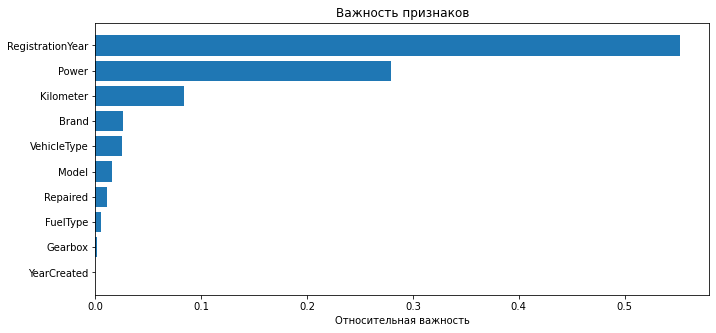

LGBMRegressor(max_depth=21, n_estimators=160,
              objective='root_mean_squared_error', random_state=123)


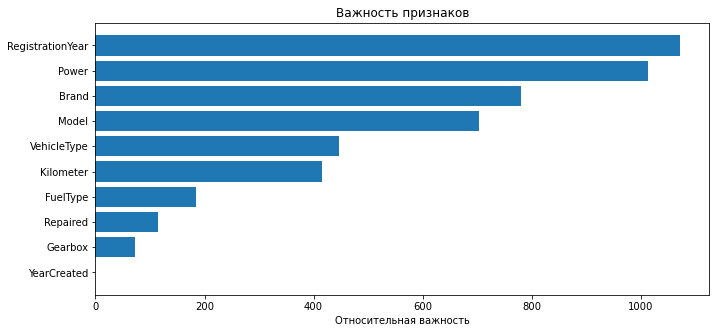

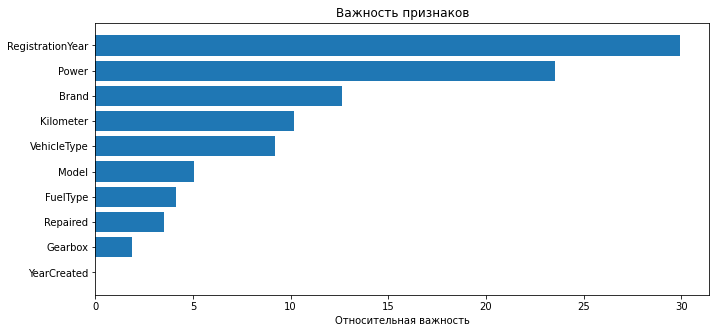

In [31]:
def disaplay_features_importances(model, features):
    features = features.columns
    n = len(features)
    
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность признаков')
    plt.barh(range(n), importances[indices])
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()

for model_results in compare:
    print(model_results[0])
    disaplay_features_importances(model_results[0], features_valid)
    

Все модели наиболее важными признаками посчтилаи RegistrationYear (год регистрации автомобиля) и Power (мощность его двигателя). Также к важным у всех относится и Kilometers (пробег). Более сложные модели -- LGBMRegressor и CatBoostRegressor также значительное влияние уделяют бренду и модели автомобиля, тогда как RandomForestRegressor, который показал значительно худшее качество, -- нет. Вероятно, в этом заключается основная его проблема

# 5. Проверка модели<a class="anchor" id="b5"></a>


Проверим качество выбранной модели на тестовой выборке: rmse должна быть не больше 2500.

In [32]:
best_model = best_lgbm

print('Выбранная модель:', best_model)
start = time()           
best_model.fit(features_train, target_train)
end = time()
best_model_time_train = end - start
print("Время обучения", best_model_time_train)
            
start = time()
best_model_predictions_test = best_cat.predict(features_test)
end = time()
best_model_time_pred = end - start
print("Время предсказания", best_model_time_pred)
            
best_model_rmse_test = mean_squared_error(target_test, best_model_predictions_test, squared=False)
print('RMSE на тестовой выборке:', best_model_rmse_test)

Выбранная модель: LGBMRegressor(max_depth=21, n_estimators=160,
              objective='root_mean_squared_error', random_state=123)
Время обучения 0.6425373554229736
Время предсказания 0.029996633529663086
RMSE на тестовой выборке: 1567.9662091782106


In [33]:
test_mean_rmse = mean_squared_error(target_test, [target_test.mean()]*len(target_test)) ** 0.5
test_median_rmse = mean_squared_error(target_test, [target_test.median()]*len(target_test)) ** 0.5
level = min(test_mean_rmse,test_median_rmse) 
print('лучший rmse константной модели',level)

лучший rmse константной модели 4543.78418860805


Таким образом, задание выполнено: с учетом сравнения различных моделей по качеству и времени обучения и предсказания построена и обучена модель, удовлетворяющая требуемому качеству предсказаний.